In [1]:
%reload_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from glob import glob
import wave
import math

import numpy as np

import essentia.standard as es
import librosa

import tensorflow as tf
from model.fp.melspec.melspectrogram import get_melspec_layer
from run import load_config
from model.utils.audio_utils import load_audio

2023-06-22 12:43:38.537098: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[   INFO   ] MusicExtractorSVM: no classifier models were configured by default
2023-06-22 12:43:39.308187: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 12:43:39.310510: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-06-22 12:43:40.862185: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-22 12:43:40.862347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving 

## Audio Directories 

In [2]:
DISCOTUBE = "/mnt/projects/discotube/discotube-2023-03/audio-new/audio/"
audio_directories = os.listdir(DISCOTUBE)
audio_directory = audio_directories[0]
mp4_paths = glob(os.path.join(DISCOTUBE, audio_directory, "*.mp4"))
mp4_path = mp4_paths[0]

In [3]:
audio_dir = "/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/"
audio_paths = glob(os.path.join(audio_dir, "*/*.wav"))
print(len(audio_paths))

9978


## NAFP Melspec

In [5]:
cfg = load_config("default")
melspec_layer = get_melspec_layer(cfg)

print(cfg["MODEL"])

fs = cfg["MODEL"]["FS"]

cli: Configuration from ./config/default.yaml


2023-06-21 14:17:28.676159: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


{'FEAT': 'melspec', 'FS': 8000, 'DUR': 1.0, 'HOP': 0.5, 'STFT_WIN': 1024, 'STFT_HOP': 256, 'F_MIN': 300.0, 'F_MAX': 4000.0, 'N_MELS': 256, 'EMB_SZ': 128, 'BN': 'layer_norm2d', 'SEGMENT_NORM': False}


In [15]:
for audio_path in audio_paths:
    audio = load_audio(audio_path, 0.0, 0.0, 10.0, 0.0, fs, 'normal')
    mel_spec = melspec_layer(audio.reshape(1, 1, -1)).numpy()
    if mel_spec.min()<-3:
        print(mel_spec.min(), mel_spec.max())

In [63]:
for audio_path in audio_paths:
    audio = load_audio(audio_path, 0.0, 0.0, 10.0, 0.0, fs, 'normal')
    x = melspec_layer.m(audio.reshape(1, 1, -1)) + 0.06
    x = tf.math.log(tf.maximum(x, melspec_layer.amin)) / math.log(10)
    x = x - tf.reduce_max(x)
    val = tf.reduce_min(x).numpy()
    if val < -5:
        print(val)

In [30]:
audio = load_audio(audio_paths[6], 0.0, 0.0, 10.0, 0.0, fs, 'normal')

# Amplitude Mel-Spectrogram
x = melspec_layer.m(audio.reshape(1, 1, -1))
# Clip x below from amin
x = tf.maximum(x, 1e-5)
# log-power Mel-spectrogram
x_ref = tf.reduce_max(x) # Reference is the maximum value of x
x = 10*tf.math.log(x**2/x_ref**2)/ tf.math.log(tf.constant(10, dtype=x.dtype))
# Clip x below from -dynamic_range dB
x = tf.maximum(x, -80)
# Normalize x to be in [0, 1]
x = 1 + (x/80)

In [32]:
print(tf.reduce_min(x), tf.reduce_max(x))

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [39]:
cfg = load_config("default")
melspec_layer = get_melspec_layer(cfg)

print(cfg["MODEL"])

fs = cfg["MODEL"]["FS"]

cli: Configuration from ./config/default.yaml
{'FEAT': 'melspec', 'FS': 8000, 'DUR': 1.0, 'HOP': 0.5, 'STFT_WIN': 1024, 'STFT_HOP': 256, 'F_MIN': 300.0, 'F_MAX': 4000.0, 'N_MELS': 256, 'EMB_SZ': 128, 'BN': 'layer_norm2d', 'SEGMENT_NORM': True}


In [ ]:
for audio_path in audio_paths:
    audio = load_audio(audio_path, 0.0, 0.0, 10.0, 0.0, fs, 'normal')
    mel_spec = melspec_layer(audio.reshape(1, 1, -1)).numpy()
    print(mel_spec.min(), mel_spec.max())

In [32]:
audio = load_audio(audio_paths[0], 0.0, 0.0, 10.0, 0.0, fs, 'normal')
mel_spec = melspec_layer(audio.reshape(1, 1, -1)).numpy()
mel_spec = mel_spec.reshape(mel_spec.shape[1], mel_spec.shape[2])
print(mel_spec.shape)
print(mel_spec.min(), mel_spec.max())

(256, 313)
-80.0 0.0


In [33]:
mel_spec_librosa = librosa.feature.melspectrogram(y=audio, 
                                                sr=fs, 
                                                n_fft=cfg["MODEL"]["STFT_WIN"], 
                                                hop_length=cfg["MODEL"]["STFT_HOP"],
                                                n_mels=cfg["MODEL"]["N_MELS"],
                                                fmin=cfg["MODEL"]["F_MIN"],
                                                fmax=cfg["MODEL"]["F_MAX"],
                                                center=True,
                                                #pad_mode="center",
                                                power=2)
print(mel_spec_librosa.shape)
mel_spec_librosa = 10*np.log10(mel_spec_librosa/np.max(mel_spec_librosa))
mel_spec_librosa = np.where(mel_spec_librosa>=-80, mel_spec_librosa, -80)
print(mel_spec_librosa.min(), mel_spec_librosa.max())

(256, 313)
-80.0 0.0


In [34]:
np.allclose(mel_spec, mel_spec_librosa, atol=1e-1)

False

In [35]:
mel_spec

array([[-36.68943 , -21.742113, -20.309765, ..., -19.822012, -20.489365,
        -24.145638],
       [-36.938984, -24.977938, -21.445936, ..., -27.986769, -28.033638,
        -29.870455],
       [-37.87073 , -30.565044, -24.64006 , ..., -26.313152, -25.039806,
        -24.922733],
       ...,
       [-79.64657 , -65.56791 , -56.17618 , ..., -55.69545 , -55.18178 ,
        -49.996162],
       [-80.      , -80.      , -75.46232 , ..., -66.33388 , -63.963314,
        -51.220177],
       [-80.      , -80.      , -80.      , ..., -80.      , -67.040184,
        -51.65086 ]], dtype=float32)

In [31]:
mel_spec_librosa

array([[-37.11386749, -22.11639493, -20.73415837, ..., -19.70487733,
        -20.10804385, -23.49306332],
       [-37.35740441, -25.02066466, -21.77221545, ..., -27.34627797,
        -28.37688437, -29.90850058],
       [-38.27259395, -30.67714086, -24.86745692, ..., -24.88787459,
        -24.69978753, -25.06100411],
       ...,
       [-77.952984  , -64.63177147, -55.13583889, ..., -55.4160699 ,
        -54.41510101, -50.21485826],
       [-80.        , -77.14191433, -71.42757918, ..., -64.99154154,
        -62.8093846 , -51.62960975],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -67.3180574 , -52.06569105]])

## Audio Loading 

Essentia vs Wave

In [6]:
fs = 8000
T = 20.0

audio_path = audio_paths[0]


In [7]:
nafp_audio = load_audio(audio_path, 0.0, 0.0, T, 0.0, fs, 'normal')
print(nafp_audio.shape)

(160000,)


In [8]:
loader = es.AudioLoader(filename=audio_path)
essentia_audio,_,_,_,_,_ = loader()
if not np.any(essentia_audio[:,1]):
    essentia_audio = essentia_audio[:,0]
essentia_audio = essentia_audio[:int(T*fs)]
print(essentia_audio.shape)

(160000,)


In [ ]:
for audio_path in audio_paths:
    nafp_audio = load_audio(audio_path, 0.0, 0.0, T, 0.0, fs, 'normal')
    loader = es.AudioLoader(filename=audio_path)
    essentia_audio,_,_,_,_,_ = loader()
    if not np.any(essentia_audio[:,1]):
        essentia_audio = essentia_audio[:,0]
    essentia_audio = essentia_audio[:int(T*fs)]
    if not np.all(nafp_audio==essentia_audio):
        print(audio_path)

### MonoLoader vs AudioLoader

In [ ]:
for audio_path in audio_paths:
    essentia_audio0,_,_,_,_,_ = es.AudioLoader(filename=audio_path)()
    essentia_audio1 = es.MonoLoader(filename=audio_path, sampleRate=fs)()
    if not np.any(essentia_audio0[:,1]):
        essentia_audio0 = essentia_audio0[:,0]
    if not np.all(essentia_audio0==essentia_audio1):
        print(audio_path)

## Compare Melspecs

In [44]:
import tensorflow as tf

import matplotlib.pyplot as plt

In [59]:
cfg = load_config("default")
cfg["MODEL"]

cli: Configuration from ./config/default.yaml


{'FEAT': 'melspec',
 'FS': 8000,
 'DUR': 1.0,
 'HOP': 0.5,
 'STFT_WIN': 1024,
 'STFT_HOP': 256,
 'F_MIN': 300.0,
 'F_MAX': 4000.0,
 'N_MELS': 256,
 'EMB_SZ': 128,
 'BN': 'layer_norm2d',
 'SEGMENT_NORM': False}

In [19]:
segment_size = int(cfg["MODEL"]["DUR"]*cfg["MODEL"]["FS"])

511.99997


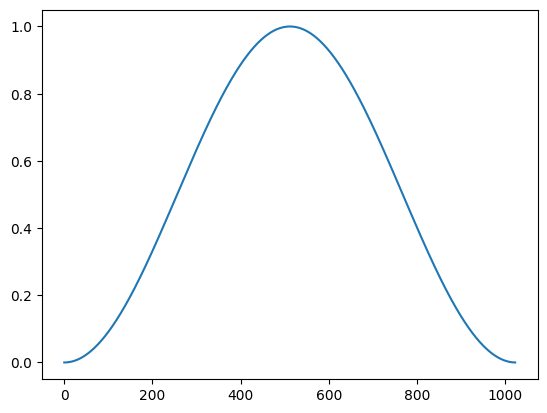

In [57]:
# Create the window
tf_window = tf.signal.hann_window(cfg["MODEL"]["STFT_WIN"])
print(np.sum(tf_window.numpy()))
plt.plot(tf_window.numpy())
plt.show()

512.0


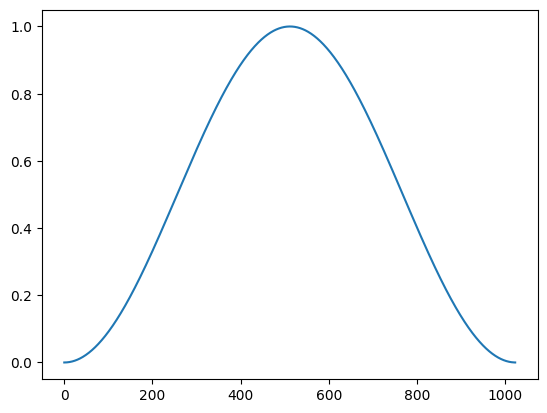

In [186]:
essentia_window_fn = es.Windowing(type="hann", 
                               normalized=False, # Seems like tf is not normalized
                               size=cfg["MODEL"]["STFT_WIN"],
                               symmetric=False, # Why for spectral analysis is not symmetric?
                               zeroPhase=False, # ??
                               )
essentia_window = essentia_window_fn(np.ones(cfg["MODEL"]["STFT_WIN"], dtype=np.float32))
print(np.sum(essentia_window))
plt.plot(essentia_window)
plt.show()

In [202]:
# Create the window
essentia_window_fn = es.Windowing(type="hann", 
                               normalized=False, # Seems like tf is not normalized
                               size=cfg["MODEL"]["STFT_WIN"],
                               symmetric=False, # Why for spectral analysis is not symmetric?
                               zeroPhase=False, # Probably not important since we are using amplitude spectrogram?
                               )

# Create the frame generator
frame_generator = lambda x: es.FrameGenerator(x, 
                            frameSize=cfg["MODEL"]["STFT_WIN"], 
                            hopSize=cfg["MODEL"]["STFT_HOP"], 
                            startFromZero=True, # Do not zero-center the window to the first frame
                            lastFrameToEndOfFile=False,
                            validFrameThresholdRatio=1.0, # Discard if small frames are left at the end
                            )

# Define the FFT
spec = es.Spectrum(size=cfg["MODEL"]["STFT_WIN"])

# Define the Mel bands
mb = es.MelBands(
    highFrequencyBound=4000,
    inputSize=cfg["MODEL"]["STFT_WIN"] // 2 + 1,
    log=False,
    lowFrequencyBound=300,
    normalize="unit_tri",
    numberBands=256,
    sampleRate=cfg["MODEL"]["FS"],
    type="magnitude",
    warpingFormula="slaneyMel",
    weighting="linear",
)

#1 Load Audio
audio_path = audio_paths[0]
audio = es.MonoLoader(filename=audio_path, sampleRate=cfg["MODEL"]["FS"])()

essentia_mel_spec = []
for i in range(len(audio)//segment_size):

    #2 Get a segment of audio
    audio_segment = audio[i*segment_size:(i+1)*segment_size]

    #3 Pad the segment from both sides
    # Effectively, zero-centering the window to the first frame of the segment
    audio_segment = np.concatenate((np.zeros(cfg["MODEL"]["STFT_WIN"]//2), audio_segment, np.zeros(cfg["MODEL"]["STFT_WIN"]//2))).astype(np.float32)

    #4 Compute STFT for the segment by frameing, windowing and FFT
    
    for frame in frame_generator(audio_segment):
        s = mb(spec(essentia_window_fn(frame)))
        essentia_mel_spec.append(s)
essentia_mel_spec = np.array(essentia_mel_spec)
essentia_mel_spec.shape

(928, 256)

In [177]:
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel

In [178]:
kapre_stft_fn = STFT(n_fft=cfg["MODEL"]["STFT_WIN"],
                win_length=cfg["MODEL"]["STFT_WIN"],
                hop_length=cfg["MODEL"]["STFT_HOP"],
                window_name="hann_window",
                pad_begin=False,
                pad_end=False,
                input_data_format="channels_first",
                output_data_format="channels_first",
)

In [199]:
audio_path = audio_paths[0]
audio = es.MonoLoader(filename=audio_path, sampleRate=cfg["MODEL"]["FS"])()

kapre_stft = []
for i in range(len(audio)//segment_size):

    #2 Get a segment of audio
    audio_segment = audio[i*segment_size:(i+1)*segment_size]

    #3 Pad the segment
    audio_segment = np.concatenate((np.zeros(cfg["MODEL"]["STFT_WIN"]//2), audio_segment, np.zeros(cfg["MODEL"]["STFT_WIN"]//2))).astype(np.float32)

    kapre_stft.append(kapre_stft_fn(audio_segment.reshape(1, 1,-1)).numpy()[0,0,:,:])
    
kapre_stft = np.concatenate(kapre_stft, axis=0)
kapre_stft = np.abs(kapre_stft)
kapre_stft.shape

(928, 513)

In [213]:
np.max(np.abs(essentia_stft-kapre_stft))

0.0

### Use NAFP Melspec

In [206]:
def calculate_mel_spec(audio):

    # Create the window
    essentia_window_fn = es.Windowing(type="hann", 
                                normalized=False, # Seems like tf is not normalized
                                size=cfg["MODEL"]["STFT_WIN"],
                                symmetric=False, # Why for spectral analysis is not symmetric?
                                zeroPhase=False, # Probably not important since we are using amplitude spectrogram?
                                )

    # Create the frame generator
    frame_generator = lambda x: es.FrameGenerator(x, 
                                frameSize=cfg["MODEL"]["STFT_WIN"], 
                                hopSize=cfg["MODEL"]["STFT_HOP"], 
                                startFromZero=True, # Do not zero-center the window to the first frame
                                lastFrameToEndOfFile=False,
                                validFrameThresholdRatio=1.0, # Discard if small frames are left at the end
                                )

    # Define the FFT
    spec = es.Spectrum(size=cfg["MODEL"]["STFT_WIN"])

    # Define the Mel bands
    mb = es.MelBands(
        highFrequencyBound=4000,
        inputSize=cfg["MODEL"]["STFT_WIN"] // 2 + 1,
        log=False,
        lowFrequencyBound=300,
        normalize="unit_tri",
        numberBands=256,
        sampleRate=cfg["MODEL"]["FS"],
        type="magnitude",
        warpingFormula="slaneyMel",
        weighting="linear",
    )

    #1 Load Audio
    #audio = es.MonoLoader(filename=audio_path, sampleRate=cfg["MODEL"]["FS"])()

    essentia_mel_spec = []
    for i in range(len(audio)//segment_size):

        #2 Get a segment of audio
        audio_segment = audio[i*segment_size:(i+1)*segment_size]

        #3 Pad the segment from both sides
        # Effectively, zero-centering the window to the first frame of the segment
        audio_segment = np.concatenate((np.zeros(cfg["MODEL"]["STFT_WIN"]//2), audio_segment, np.zeros(cfg["MODEL"]["STFT_WIN"]//2))).astype(np.float32)

        #4 Compute STFT for the segment by frameing, windowing and FFT
        
        for frame in frame_generator(audio_segment):
            s = mb(spec(essentia_window_fn(frame)))
            essentia_mel_spec.append(s)
    essentia_mel_spec = np.array(essentia_mel_spec)
    return essentia_mel_spec

In [203]:
cfg = load_config("default")
melspec_layer = get_melspec_layer(cfg)

cli: Configuration from ./config/default.yaml


In [222]:
np.log10(1e-10)

-10.0

In [221]:
audio_path = audio_paths[0]

audio = es.MonoLoader(filename=audio_path, sampleRate=cfg["MODEL"]["FS"])()

for audio_chunk in es.FrameGenerator(audio, frameSize=int(cfg["MODEL"]["DUR"]*cfg["MODEL"]["FS"]), hopSize=int(cfg["MODEL"]["HOP"]*cfg["MODEL"]["FS"])):

    mel_spec_nafp = melspec_layer(audio_chunk.reshape(1, 1, -1)).numpy()[0,:,:,0].T

    mel_spec_essentia = calculate_mel_spec(audio_chunk)

    print(np.max(np.abs(mel_spec_nafp-mel_spec_essentia)))


0.00010585785
0.00034427643
0.00035369396
0.00017595291
0.00011456013
8.2314014e-05
9.548664e-05
0.00015938282
0.00020694733
0.0004928112
0.0005021095
0.00016599894
0.00016760826
0.00013411045
9.161234e-05
8.675456e-05
7.3611736e-05
6.890297e-05
7.82609e-05
0.00012338161
0.00011447072
0.000120937824
0.00021386147
0.00021266937
0.0001424551
0.00014346838
6.15716e-05
6.771088e-05
6.908178e-05
6.380677e-05
9.36985e-05
8.869171e-05
7.56979e-05
7.510185e-05
6.765127e-05
3.9458275e-05
5.3167343e-05
8.249283e-05
0.00013422966
0.0001487732
8.094311e-05
5.531311e-05
5.5909157e-05
5.6028366e-05
6.651878e-05
7.981062e-05
6.4730644e-05
5.120039e-05
4.965067e-05
5.0246716e-05
5.286932e-05
7.44462e-05
8.2075596e-05
4.6372414e-05
6.6906214e-05
6.619096e-05
7.891655e-05
9.346008e-05
8.904934e-05
5.4597855e-05
5.310774e-05


## MelSpec Class

In [4]:
from model.fp.melspec.melspectrogram import Melspec_layer_essentia

In [6]:
cfg = load_config("default")
cfg["MODEL"]

cli: Configuration from ./config/default.yaml


{'FEAT': 'melspec',
 'FS': 8000,
 'DUR': 1.0,
 'HOP': 0.5,
 'STFT_WIN': 1024,
 'STFT_HOP': 256,
 'F_MIN': 300.0,
 'F_MAX': 4000.0,
 'N_MELS': 256,
 'EMB_SZ': 128,
 'BN': 'layer_norm2d',
 'SEGMENT_NORM': True}

In [9]:
melspec_layer = get_melspec_layer(cfg)

In [11]:
melspec_layer_es = Melspec_layer_essentia()

In [17]:
for audio_path in audio_paths:

    audio = es.MonoLoader(filename=audio_path, sampleRate=cfg["MODEL"]["FS"])()

    for audio_chunk in es.FrameGenerator(audio, frameSize=int(cfg["MODEL"]["DUR"]*cfg["MODEL"]["FS"]), hopSize=int(cfg["MODEL"]["HOP"]*cfg["MODEL"]["FS"])):

        mel_spec_nafp = melspec_layer(audio_chunk.reshape(1, 1, -1)).numpy()[0,:,:,0].T
        mel_spec_essentia = melspec_layer_es.call(audio_chunk)

        diff = np.max(np.abs(mel_spec_nafp-mel_spec_essentia))
        if diff>1:
            print(audio_path)
            print(diff)
            print()
        elif diff>0.5:
            print(diff)

/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.8398743

0.71445465
/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.7296829

/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.1340256

/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.1050491

0.56591797
/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.7495804

/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.0490952

/home/oaraz/nextcore/afp/neural-audio-fp-dataset/music/test-dummy-db-100k-full/from_fma_large10k-30s_for_mini/000/000346.wav
1.227768

0.97817993
/home/oaraz/next

KeyboardInterrupt: 

In [11]:
melspec_layer_es = Melspec_layer_essentia()

In [14]:
audio = es.MonoLoader(filename=audio_paths[0], sampleRate=cfg["MODEL"]["FS"])()
print(audio.shape)

for audio_chunk in es.FrameGenerator(audio, frameSize=int(cfg["MODEL"]["DUR"]*cfg["MODEL"]["FS"]), hopSize=int(cfg["MODEL"]["HOP"]*cfg["MODEL"]["FS"])):

    mel_spec_essentia = melspec_layer_es.compute_single(audio_chunk)

    print(mel_spec_essentia.shape)

(239909,)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)
(32, 256)


In [ ]:
for audio_path in audio_paths:

    audio = es.MonoLoader(filename=audio_path, sampleRate=cfg["MODEL"]["FS"])()

    for audio_chunk in es.FrameGenerator(audio, frameSize=int(cfg["MODEL"]["DUR"]*cfg["MODEL"]["FS"]), hopSize=int(cfg["MODEL"]["HOP"]*cfg["MODEL"]["FS"])):

        mel_spec_essentia = melspec_layer_es.call(audio_chunk)